In [1]:
# Load the huggingface sst2 dataset
from datasets import load_dataset

dataset = load_dataset("sst2")


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})
{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0}


In [3]:
num_labels = len(set(dataset["train"]["label"]))
print(num_labels)

2


In [4]:
from transformers import AutoTokenizer, RobertaModel, RobertaForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# model = RobertaModel.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Get the LoRA model
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=['query', 'key', 'value'],
    task_type=TaskType.SEQ_CLS
)

lora_model = get_peft_model(model, lora_config)

total_params = sum(param.numel() for param in lora_model.parameters())
trainable_params = sum(param.numel() for param in lora_model.parameters() if param.requires_grad)
print(f"Total params: {total_params}")
print(f"Trainable params: {trainable_params}")
print(f"Percentage trainable: {trainable_params / total_params * 100:.2f}%")

Total params: 125681668
Trainable params: 1034498
Percentage trainable: 0.82%


In [6]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Print the first example of the training set
print(tokenized_dataset["train"][0])



{'idx': 0, 'sentence': 'hide new secretions from the parental units ', 'label': 0, 'input_ids': [0, 37265, 92, 3556, 2485, 31, 5, 20536, 2833, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [7]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric
import numpy as np
import logging

metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    result = metric.compute(predictions=predictions, references=labels)

    return result


logging.basicConfig(level=logging.INFO)

step_size = 100
lr = 5e-4

training_args = TrainingArguments(
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=step_size,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=step_size,
    output_dir='./lora_results',
    overwrite_output_dir=True,
    save_steps=step_size,
    save_total_limit=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    learning_rate=lr,
    # warmup_steps=500,
)

trainer = Trainer(
    model=lora_model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"], 
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()




C:\Users\Shaobo Liang\AppData\Local\Temp\ipykernel_47232\513684270.py:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\datasets\load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is

{'loss': 0.6762, 'learning_rate': 0.000497030526190759, 'epoch': 0.01}


                                                   
  1%|          | 100/16838 [00:24<30:45,  9.07it/s]Checkpoint destination directory ./lora_results\checkpoint-100 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.503141462802887, 'eval_accuracy': 0.8245412844036697, 'eval_runtime': 11.9692, 'eval_samples_per_second': 72.854, 'eval_steps_per_second': 18.213, 'epoch': 0.01}


  1%|          | 200/16838 [00:37<36:05,  7.68it/s]  

{'loss': 0.533, 'learning_rate': 0.000494061052381518, 'epoch': 0.01}


                                                   
  1%|          | 200/16838 [00:49<36:05,  7.68it/s]Checkpoint destination directory ./lora_results\checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.33361417055130005, 'eval_accuracy': 0.8990825688073395, 'eval_runtime': 11.8169, 'eval_samples_per_second': 73.792, 'eval_steps_per_second': 18.448, 'epoch': 0.01}


  2%|▏         | 300/16838 [01:02<36:01,  7.65it/s]   

{'loss': 0.4371, 'learning_rate': 0.000491091578572277, 'epoch': 0.02}


                                                   
  2%|▏         | 300/16838 [01:14<36:01,  7.65it/s]Checkpoint destination directory ./lora_results\checkpoint-300 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.2798396050930023, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 11.7922, 'eval_samples_per_second': 73.947, 'eval_steps_per_second': 18.487, 'epoch': 0.02}


  2%|▏         | 400/16838 [01:26<36:05,  7.59it/s]   

{'loss': 0.482, 'learning_rate': 0.000488122104763036, 'epoch': 0.02}


                                                   
  2%|▏         | 400/16838 [01:38<36:05,  7.59it/s]Checkpoint destination directory ./lora_results\checkpoint-400 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3326576054096222, 'eval_accuracy': 0.9025229357798165, 'eval_runtime': 11.7159, 'eval_samples_per_second': 74.429, 'eval_steps_per_second': 18.607, 'epoch': 0.02}


  3%|▎         | 500/16838 [01:51<36:06,  7.54it/s]   

{'loss': 0.4688, 'learning_rate': 0.000485152630953795, 'epoch': 0.03}


                                                   
  3%|▎         | 500/16838 [02:03<36:06,  7.54it/s]Checkpoint destination directory ./lora_results\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3038271367549896, 'eval_accuracy': 0.9208715596330275, 'eval_runtime': 11.8086, 'eval_samples_per_second': 73.844, 'eval_steps_per_second': 18.461, 'epoch': 0.03}


  4%|▎         | 600/16838 [02:16<35:23,  7.65it/s]   

{'loss': 0.5377, 'learning_rate': 0.000482183157144554, 'epoch': 0.04}


                                                   
  4%|▎         | 600/16838 [02:27<35:23,  7.65it/s]Checkpoint destination directory ./lora_results\checkpoint-600 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.2998485863208771, 'eval_accuracy': 0.911697247706422, 'eval_runtime': 11.544, 'eval_samples_per_second': 75.537, 'eval_steps_per_second': 18.884, 'epoch': 0.04}


  4%|▍         | 700/16838 [02:40<35:01,  7.68it/s]   

{'loss': 0.4245, 'learning_rate': 0.000479213683335313, 'epoch': 0.04}


                                                   
  4%|▍         | 700/16838 [02:51<35:01,  7.68it/s]Checkpoint destination directory ./lora_results\checkpoint-700 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3971441388130188, 'eval_accuracy': 0.908256880733945, 'eval_runtime': 11.5551, 'eval_samples_per_second': 75.465, 'eval_steps_per_second': 18.866, 'epoch': 0.04}


  5%|▍         | 800/16838 [03:04<35:12,  7.59it/s]   

{'loss': 0.4591, 'learning_rate': 0.000476244209526072, 'epoch': 0.05}


                                                   
  5%|▍         | 800/16838 [03:15<35:12,  7.59it/s]Checkpoint destination directory ./lora_results\checkpoint-800 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3772496283054352, 'eval_accuracy': 0.9013761467889908, 'eval_runtime': 11.6689, 'eval_samples_per_second': 74.728, 'eval_steps_per_second': 18.682, 'epoch': 0.05}


  5%|▌         | 900/16838 [03:28<35:30,  7.48it/s]   

{'loss': 0.5147, 'learning_rate': 0.00047327473571683097, 'epoch': 0.05}


                                                   
  5%|▌         | 900/16838 [03:40<35:30,  7.48it/s]Checkpoint destination directory ./lora_results\checkpoint-900 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.4336111545562744, 'eval_accuracy': 0.9071100917431193, 'eval_runtime': 11.658, 'eval_samples_per_second': 74.798, 'eval_steps_per_second': 18.7, 'epoch': 0.05}


  6%|▌         | 1000/16838 [03:53<34:12,  7.72it/s]  

{'loss': 0.5359, 'learning_rate': 0.00047030526190759, 'epoch': 0.06}


                                                    
  6%|▌         | 1000/16838 [04:04<34:12,  7.72it/s]Checkpoint destination directory ./lora_results\checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3149067163467407, 'eval_accuracy': 0.9128440366972477, 'eval_runtime': 10.9245, 'eval_samples_per_second': 79.82, 'eval_steps_per_second': 19.955, 'epoch': 0.06}


  7%|▋         | 1100/16838 [04:16<33:17,  7.88it/s]   

{'loss': 0.5033, 'learning_rate': 0.000467335788098349, 'epoch': 0.07}


                                                    
  7%|▋         | 1100/16838 [04:28<33:17,  7.88it/s]Checkpoint destination directory ./lora_results\checkpoint-1100 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3118506669998169, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 11.0838, 'eval_samples_per_second': 78.673, 'eval_steps_per_second': 19.668, 'epoch': 0.07}


  7%|▋         | 1200/16838 [04:41<32:56,  7.91it/s]   

{'loss': 0.5255, 'learning_rate': 0.000464366314289108, 'epoch': 0.07}


                                                    
  7%|▋         | 1200/16838 [04:50<32:56,  7.91it/s]Checkpoint destination directory ./lora_results\checkpoint-1200 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.3213503658771515, 'eval_accuracy': 0.9139908256880734, 'eval_runtime': 9.7645, 'eval_samples_per_second': 89.303, 'eval_steps_per_second': 22.326, 'epoch': 0.07}


  8%|▊         | 1300/16838 [05:03<32:30,  7.97it/s]   

{'loss': 0.395, 'learning_rate': 0.00046139684047986695, 'epoch': 0.08}


                                                    
  8%|▊         | 1300/16838 [05:14<32:30,  7.97it/s]Checkpoint destination directory ./lora_results\checkpoint-1300 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.33157384395599365, 'eval_accuracy': 0.9151376146788991, 'eval_runtime': 10.8828, 'eval_samples_per_second': 80.126, 'eval_steps_per_second': 20.032, 'epoch': 0.08}


  8%|▊         | 1400/16838 [05:27<32:08,  8.00it/s]   

{'loss': 0.3893, 'learning_rate': 0.00045842736667062596, 'epoch': 0.08}


                                                    
  8%|▊         | 1400/16838 [05:38<32:08,  8.00it/s]Checkpoint destination directory ./lora_results\checkpoint-1400 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6721845269203186, 'eval_accuracy': 0.8291284403669725, 'eval_runtime': 10.9996, 'eval_samples_per_second': 79.276, 'eval_steps_per_second': 19.819, 'epoch': 0.08}


  9%|▉         | 1500/16838 [05:51<31:59,  7.99it/s]   

{'loss': 0.4985, 'learning_rate': 0.00045545789286138497, 'epoch': 0.09}


                                                    
  9%|▉         | 1500/16838 [06:02<31:59,  7.99it/s]Checkpoint destination directory ./lora_results\checkpoint-1500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.29962965846061707, 'eval_accuracy': 0.9094036697247706, 'eval_runtime': 11.1034, 'eval_samples_per_second': 78.535, 'eval_steps_per_second': 19.634, 'epoch': 0.09}


 10%|▉         | 1600/16838 [06:15<31:52,  7.97it/s]   

{'loss': 0.4036, 'learning_rate': 0.000452488419052144, 'epoch': 0.1}


                                                    
 10%|▉         | 1600/16838 [06:26<31:52,  7.97it/s]Checkpoint destination directory ./lora_results\checkpoint-1600 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.33224523067474365, 'eval_accuracy': 0.9162844036697247, 'eval_runtime': 11.063, 'eval_samples_per_second': 78.821, 'eval_steps_per_second': 19.705, 'epoch': 0.1}


 10%|█         | 1700/16838 [06:39<31:39,  7.97it/s]   

{'loss': 0.4359, 'learning_rate': 0.000449518945242903, 'epoch': 0.1}


                                                    
 10%|█         | 1700/16838 [06:50<31:39,  7.97it/s]

{'eval_loss': 0.3418334126472473, 'eval_accuracy': 0.9174311926605505, 'eval_runtime': 10.9147, 'eval_samples_per_second': 79.892, 'eval_steps_per_second': 19.973, 'epoch': 0.1}


 11%|█         | 1800/16838 [07:03<32:26,  7.73it/s]   

{'loss': 0.4396, 'learning_rate': 0.000446549471433662, 'epoch': 0.11}


                                                    
 11%|█         | 1800/16838 [07:14<32:26,  7.73it/s]

{'eval_loss': 0.41335099935531616, 'eval_accuracy': 0.8967889908256881, 'eval_runtime': 10.9886, 'eval_samples_per_second': 79.355, 'eval_steps_per_second': 19.839, 'epoch': 0.11}


 11%|█▏        | 1900/16838 [07:26<32:04,  7.76it/s]   

{'loss': 0.5066, 'learning_rate': 0.000443579997624421, 'epoch': 0.11}


                                                    
 11%|█▏        | 1900/16838 [07:37<32:04,  7.76it/s]

{'eval_loss': 0.32973578572273254, 'eval_accuracy': 0.9151376146788991, 'eval_runtime': 10.8655, 'eval_samples_per_second': 80.254, 'eval_steps_per_second': 20.064, 'epoch': 0.11}


 12%|█▏        | 2000/16838 [07:51<32:19,  7.65it/s]   

{'loss': 0.3834, 'learning_rate': 0.00044061052381517995, 'epoch': 0.12}


                                                    
 12%|█▏        | 2000/16838 [08:01<32:19,  7.65it/s]

{'eval_loss': 0.3492712080478668, 'eval_accuracy': 0.9105504587155964, 'eval_runtime': 10.9672, 'eval_samples_per_second': 79.509, 'eval_steps_per_second': 19.877, 'epoch': 0.12}


 12%|█▏        | 2100/16838 [08:14<20:58, 11.71it/s]   

{'loss': 0.3675, 'learning_rate': 0.00043764105000593896, 'epoch': 0.12}


                                                    
 12%|█▏        | 2100/16838 [08:25<20:58, 11.71it/s]

{'eval_loss': 0.295257031917572, 'eval_accuracy': 0.9162844036697247, 'eval_runtime': 11.4842, 'eval_samples_per_second': 75.931, 'eval_steps_per_second': 18.983, 'epoch': 0.12}


 13%|█▎        | 2196/16838 [08:37<28:28,  8.57it/s]  

KeyboardInterrupt: 

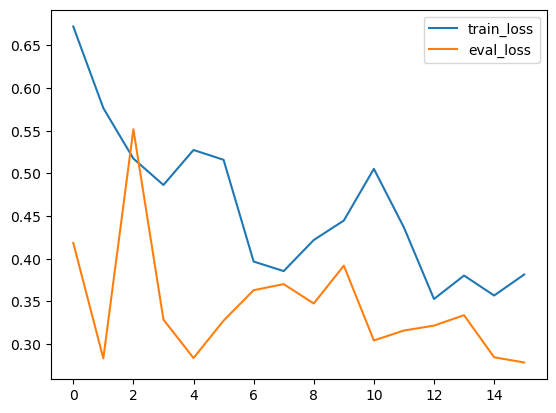

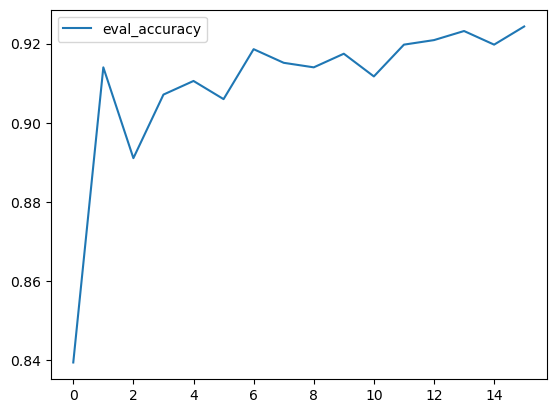

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

train_loss = []
eval_loss = []
eval_accuracy = []

for log in trainer.state.log_history:
    if 'loss' in log:
        train_loss.append(log["loss"])
    elif 'eval_loss' in log:
        eval_loss.append(log["eval_loss"])
        eval_accuracy.append(log["eval_accuracy"])

plt.plot(train_loss, label="train_loss")
plt.plot(eval_loss, label="eval_loss")
plt.legend()
plt.show()

plt.plot(eval_accuracy, label="eval_accuracy")
plt.legend()
plt.show()

In [ ]:
# Load the best model and test 

# Find the best model checkpoint
max_accuracy = 0
for log in trainer.state.log_history:
    if 'eval_accuracy' in log:
        if log['eval_accuracy'] > max_accuracy:
            max_accuracy = log['eval_accuracy']
            best_checkpoint = log['step']

print(best_checkpoint)

best_model = RobertaForSequenceClassification.from_pretrained(f"./lora_results/checkpoint-{best_checkpoint}")



16250


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
print(dataset['test'][0])
print(dataset['validation'][2])

{'idx': 0, 'sentence': 'uneasy mishmash of styles and genres .', 'label': -1}
{'idx': 2, 'sentence': 'allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . ', 'label': 1}


In [ ]:
possible_labels = set(dataset['train']['label'])
possible_test_labels = set(dataset['test']['label'])
# for i in range(100):
#     print(tokenized_dataset['test'][i]['label'])
print(possible_labels)
print(possible_test_labels)

{0, 1}
{-1}
